**My main objective**: finish the first project cycle deploying a solution to the CFO so he can make his decisions.

# 0.0. IMPORTS

In [1]:
import math
import pylab
import warnings
import inflection # used when renaming columns in subsection 1.1
import datetime

import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs

from scipy                 import stats as ss
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## Helper Functions

Here there are some functions that will be helpful in the project

In [2]:
# function to perform a correlation coeficient with categorical variables. it'll be used in section 4: EDA.
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    #correcting cramer's V bias
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# setting some notebook display as default
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
pd.set_option( 'display.float_format', lambda x: '%.2f' % x )

# setting plot parameters as default
plt.rcParams[ 'figure.figsize' ] = [25, 12]
plt.rcParams[ 'font.size' ] = 24
sns.set_style( "white" )

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory = False) # other store features

# merging datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. STEP 1: DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

We basically rename them to better manipulate and visualize the data, since the names become shortly and intuitive after renaming

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# creating new names with a snakecase pattern
snakecase = lambda x: inflection.underscore( x )

# creating a list containing the new column names
cols_new = list(map(snakecase, cols_old))

# renaming the dataframe columns
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] ) # changing 'date' column from object to pandas datetime
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checking for NANs

In [40]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5. Filling out NANs

**competition_distance:**

I'll assume that if the value is missing it's because there'no competitor close to the store. Thus if I input a distance greater than the maximum distance of the column it's the same as there'no competitor close.

The maximum distance is 75.860m. So, if the value is missing, I will input 200.000m

In [8]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

**competition_open_since_month** and **competition_open_since_year:**

There can be two reasons for missing values in this column:
- the store doesn't really have a close competitor.
- The store does have a close competitor, but we don't know when it was opened. Maybe the competitor existed before or after the store opening.

So, what I'll do: if the store has a NA in this column, I'll copy the date from this line to the competition_since_month. The main reason to do it is because I believe that this column is important to the model.

For now, it's not a big problem because I'm working in cycles. Thus, if this assumption doesn't help in the modeling performance, I handle it in the next CRISP cycle.

In [9]:
# competition_open_since_month
df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace=True )

In [10]:
# competition_open_since_year
df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace=True )

**promo2_since_week** and **promo2_since_year**:

If there are missing values in these columns, it's because the store is not participating in promo2.
So, we'll fill it out with the present date.

In [11]:
df1['promo2_since_week'].fillna( df1['date'].dt.isocalendar().week, inplace=True )
df1['promo2_since_year'].fillna( df1['date'].dt.year, inplace=True )

**promo_interval**:

In [12]:
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna('', inplace=True) 

# getting month abreviation
df1['month_map'] = df1['date'].dt.strftime( "%b" ) 

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

## 1.6. Change Data Types

Some features has float as type but they should be integer. So, they're going to be changed.

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

This subsection provides both a business notion (with metrics of dispersion and central tendency) and a detection of error in the data

In [14]:
# dividing data in numerical and categorical
num_attributes = df1.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [16]:
# Central Tendendy - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skewness, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# concatenating them and printing
m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
m

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,280.0,558.0,838.0,558.429727,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,2.0,4.0,6.0,3.998341,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,3727.0,5744.0,7856.0,5773.818972,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,405.0,609.0,837.0,633.145946,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,1.0,1.0,1.0,0.830107,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.0,0.0,1.0,0.381515,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.0,0.0,0.0,0.178647,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,710.0,2330.0,6910.0,5935.442677,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,4.0,7.0,10.0,6.786849,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2008.0,2012.0,2014.0,2010.324840,5.515591,-7.235657,124.071304


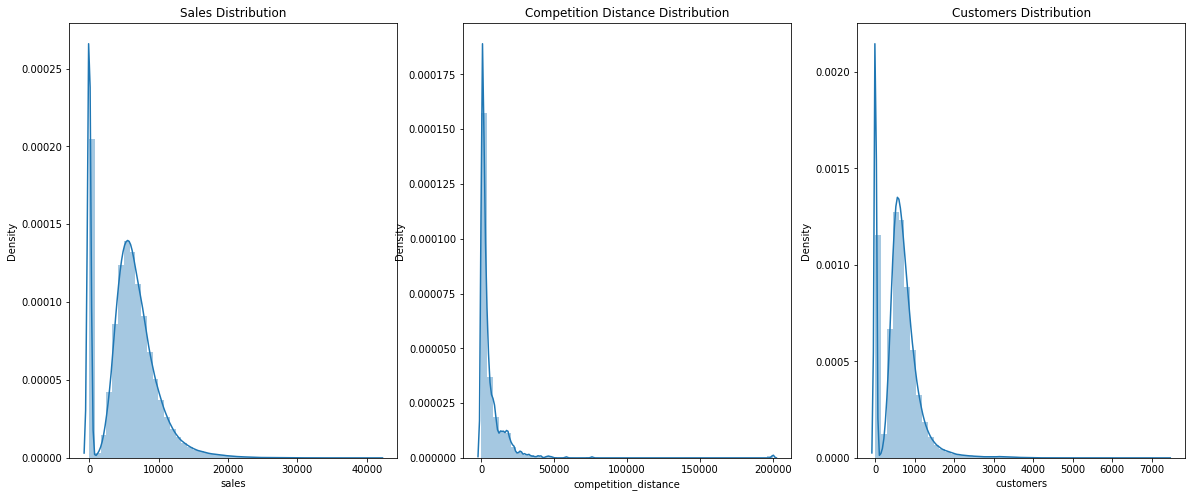

In [53]:
plt.figure(figsize=(20, 8))

plt.subplot( 1,3,1)
sns.distplot( df1['sales'] )
plt.title( 'Sales Distribution' )

plt.subplot( 1,3,2 )
sns.distplot( df1['competition_distance'] )
plt.title( 'Competition Distance Distribution' );

plt.subplot( 1,3,3 )
sns.distplot( df1['customers'] )
plt.title( 'Customers Distribution' );

In EDA Section I'll check if sales distribution is or not normal.

### 1.7.1. Categorical Attributes

In [54]:
# taking a first look at the levels of each categorical variables
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

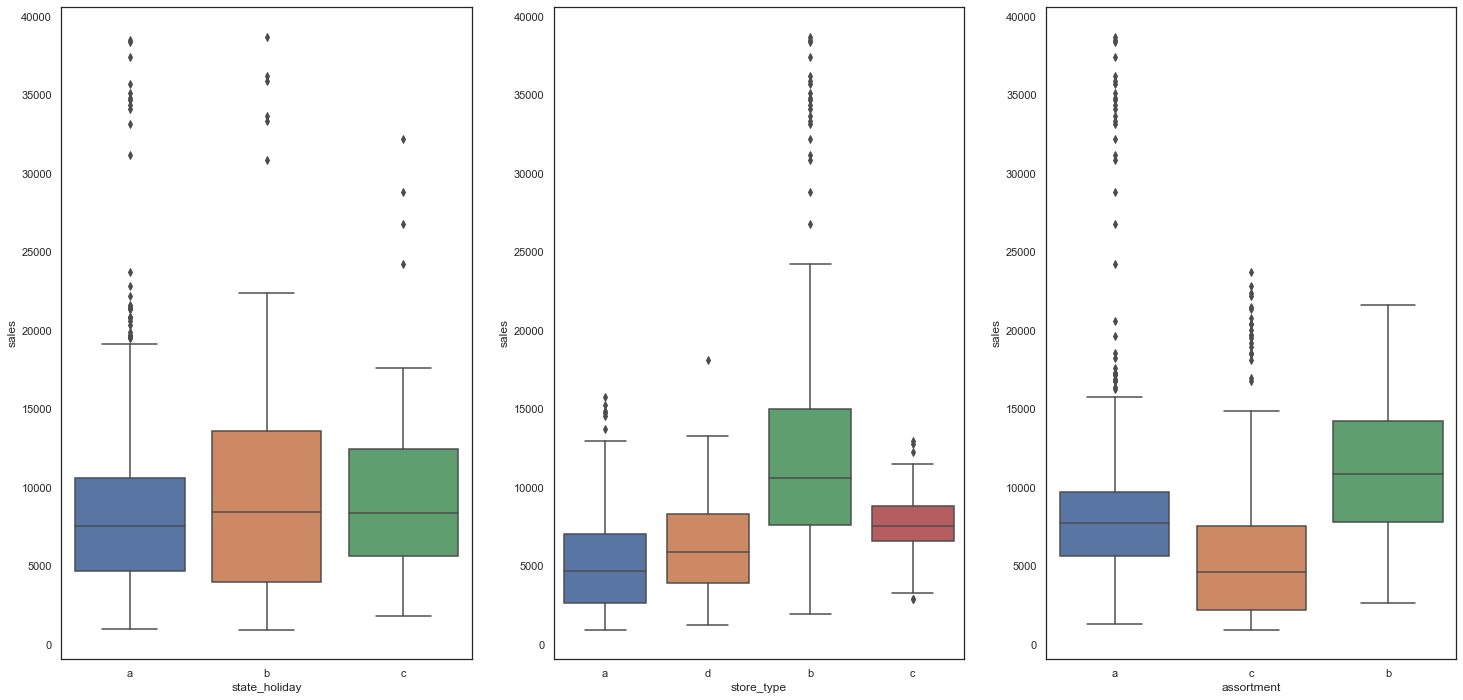

In [62]:
aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday', y ='sales', data = aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type', y ='sales', data = aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux );

# 2.0. STEP 2: FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

To better understand the relationship between the target variable (sales) and the features, I'll create some hypothesis based on the business problem to guide the feature engineering and then the exploratory data analysis.

In the EDA section, I'll validate these hypothesis and it'll let me have a good notion about the relation between the features and the target and it will help me to choose more accurately what feature to use when modeling.

However, before I do that, a mind map can be useful when creating all the hypothesis.

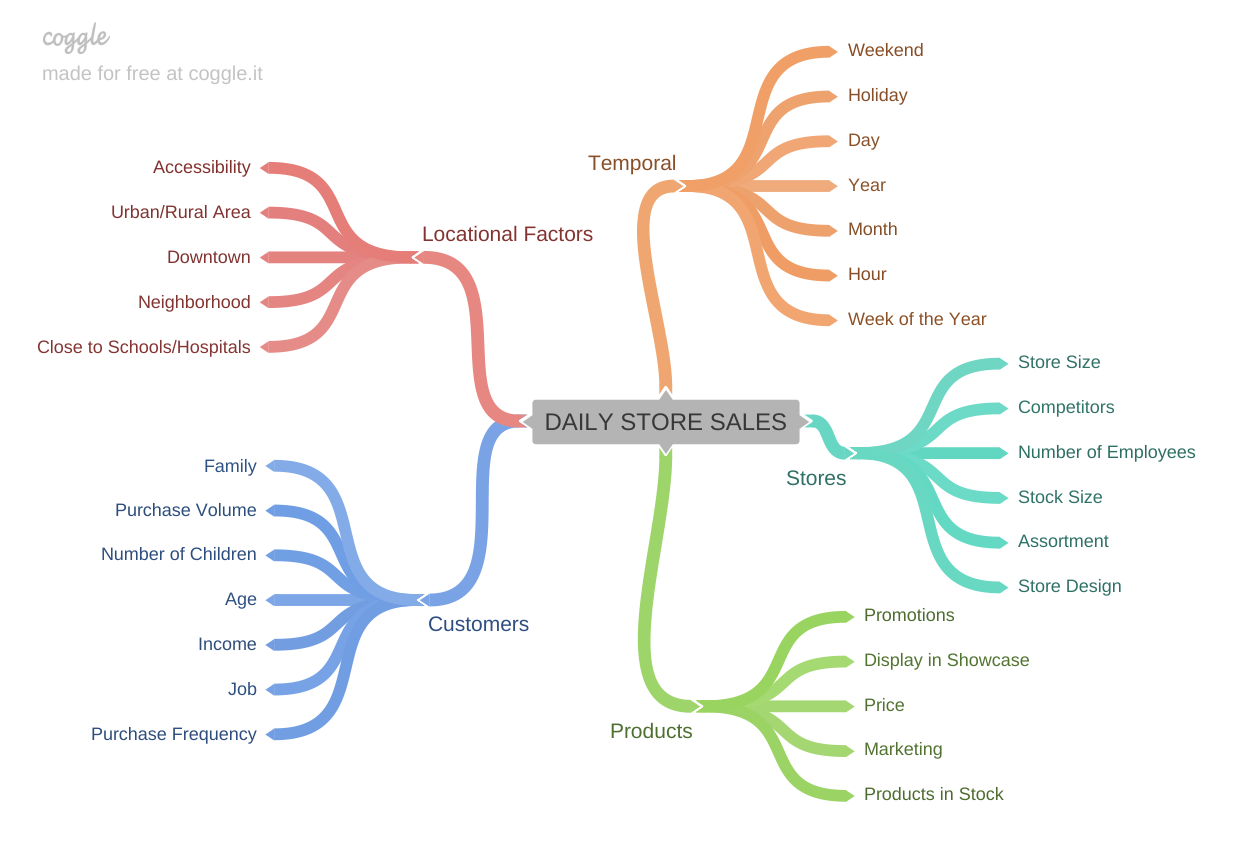

In [17]:
Image( '../img/HypMindMap.png' )

## 2.2. Hypothesis Creation

### 2.1.1. Store Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with greater stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more

### 2.1.1. Product Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.1.1. Temporal Hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should be selling more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3. Hypothesis Final List

The next step is to choose which of them will be considered in the EDA section. The criterion I'll use is the availability of the corresponding feature. For instance, there's no data for number of employees or stock size, so, their corresponding hypothesis will not be considered.

This, the following hypothesis final list is created.

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should be selling more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4. Feature Engineering

Now it's time to create some new features. It'll basically follow the needs of the list of hypothesis.

**Year, month, day, week of year and year week**

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype( int )

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

**competition since** and **promo since**

There are two columns related to competition. I'll make them only one date and then subract from the sale's date. It's the basically the same for promo since

In [17]:
# competition_since: how long the competition exists considering the purchase date
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis = 1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int ) # to get month

In [19]:
# promo_since: how long is there an active promotion
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

**assortment** and **state holiday**

In [20]:
#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

Since store type has no description in the data source, I wont change it.

# 3.0. STEP 3: FILTERING VARIABLES

In [23]:
df3 = df2.copy()

Based on business restrictions (e.g. we won't have a variable avaliable in the future to use in the prediciton), we have to properly filter variables.

## 3.1. Row Filtering

**open:** it's kind of obvious that closed stores has no sales in that day. Thus, this column also won't be used.

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

**customers:** I can't use customers because I won't have this data for the next six weeks (the prediction period) unless I build another project to predict how many customers the stores will have in that period. Since this is not the case, I'll drop it.

**promo_interval** and **month_map** were used to create new columns. They'll not be used anymore.

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )

# 4.0. STEP 4: EXPLORATORY DATA ANALYSIS

**The main goal of this section: what variables have a strong relationship with the target and how much is that relation. Baed on this relationship, I can better decide what features to use to predcit sales.**

In [26]:
df4 = df3.copy()

In [163]:
# dividing data in numerical and categorical
num_attributes = df4.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df4.select_dtypes( exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'] )

## 4.1. Univariate Analysis

### 4.1.1. Response Analysis

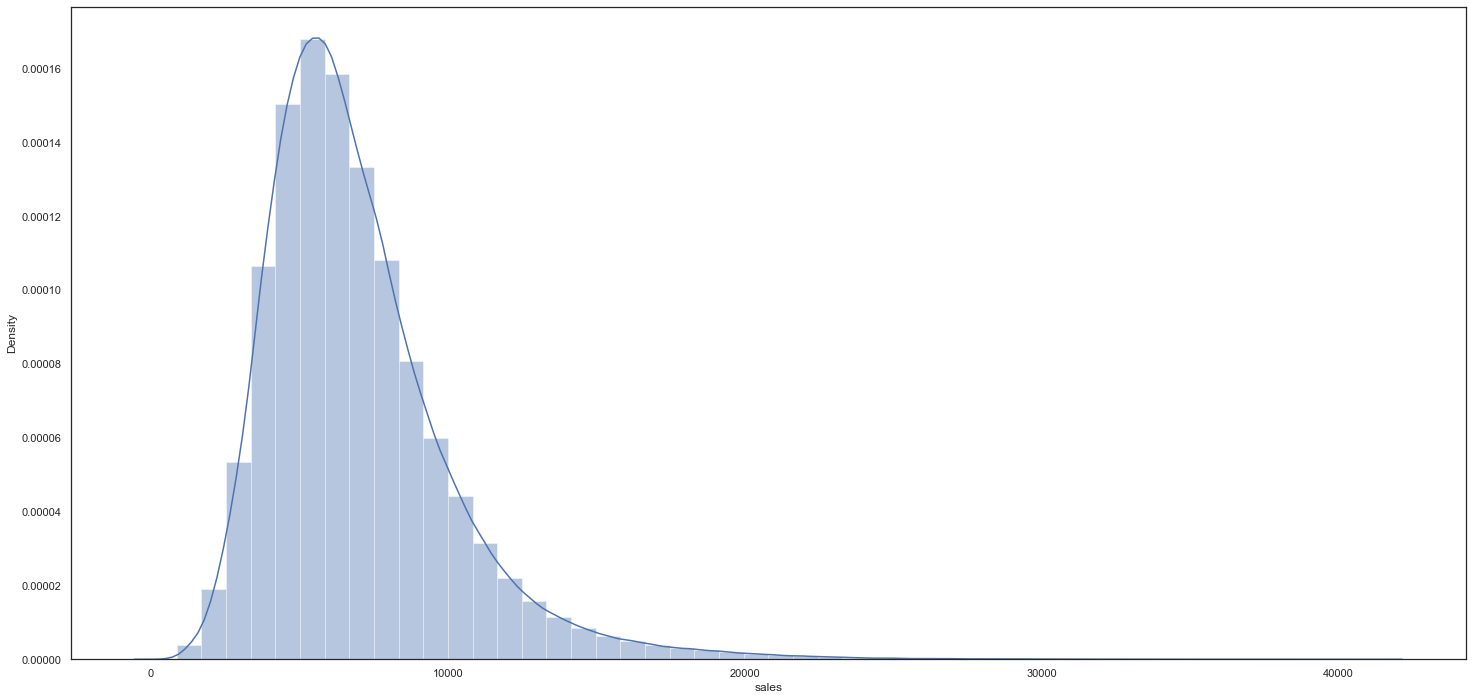

In [25]:
sns.distplot( df4['sales'] );

Some ML algorithms needs the data to be normal.
Let's check if the sales distribution is normal. First, let's look at a q-q plot and then at a Shapiro-Wilk test for normality.

As show in the plot bellow, sales distribution don't seem to be normal

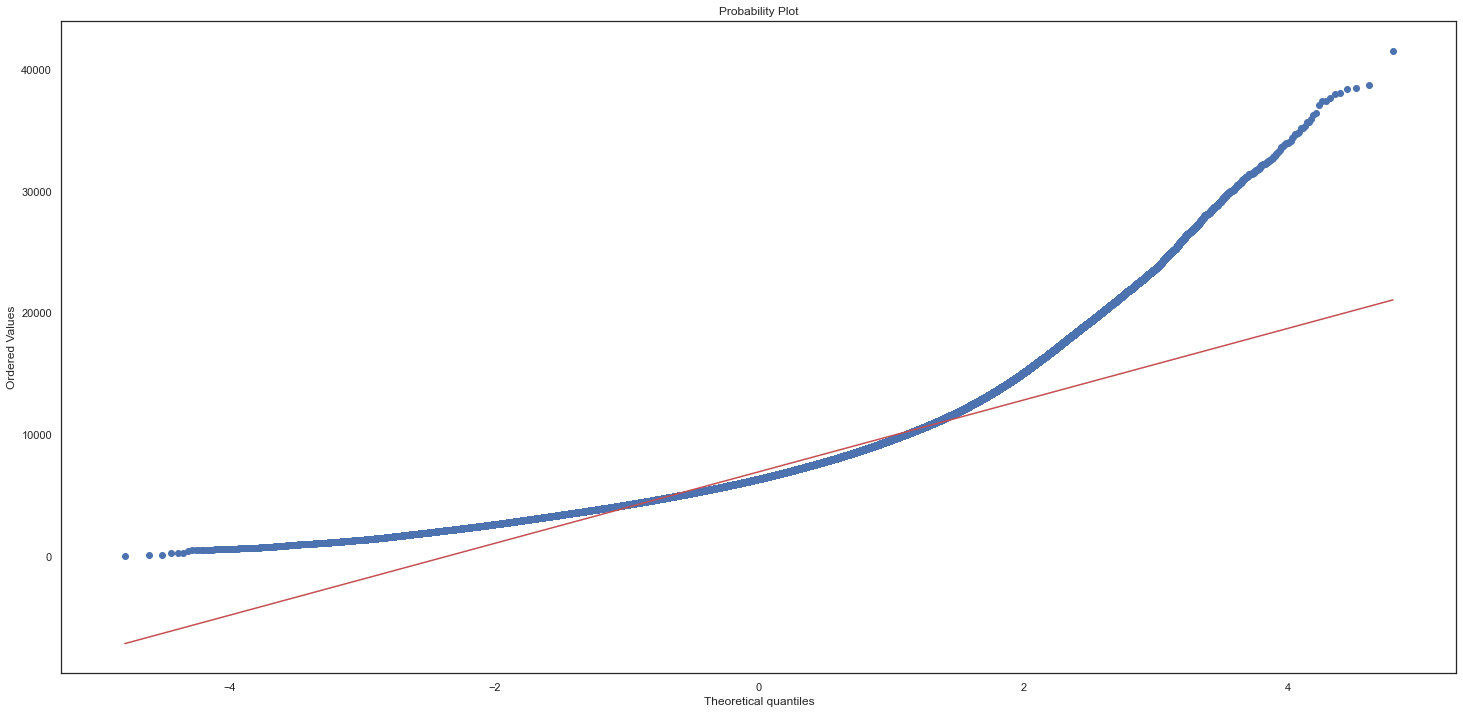

In [26]:
#sales = df4[df4['sales'] != 0]['sales']
ss.probplot( df4['sales'], dist = 'norm', plot = pylab );

In [39]:
stat, p = ss.shapiro( df4['sales'] )
print('Shapiro-Wilk test for normality: \n')
print( 'stat=%.3f, p=%.3f\n' % ( stat, p ) )
if p > 0.05:
    print( 'It\'s Probably Gaussian' )
else:
    print( 'It\'s Probably non Gaussian' )

Shapiro-Wilk test for normality: 

stat=0.902, p=0.000

It's Probably non Gaussian


**Conclusions:**

* Sales distribution is not normal. Thus, I'll have to change it later for a better prediction performance

### 4.1.2. Numerical Variables

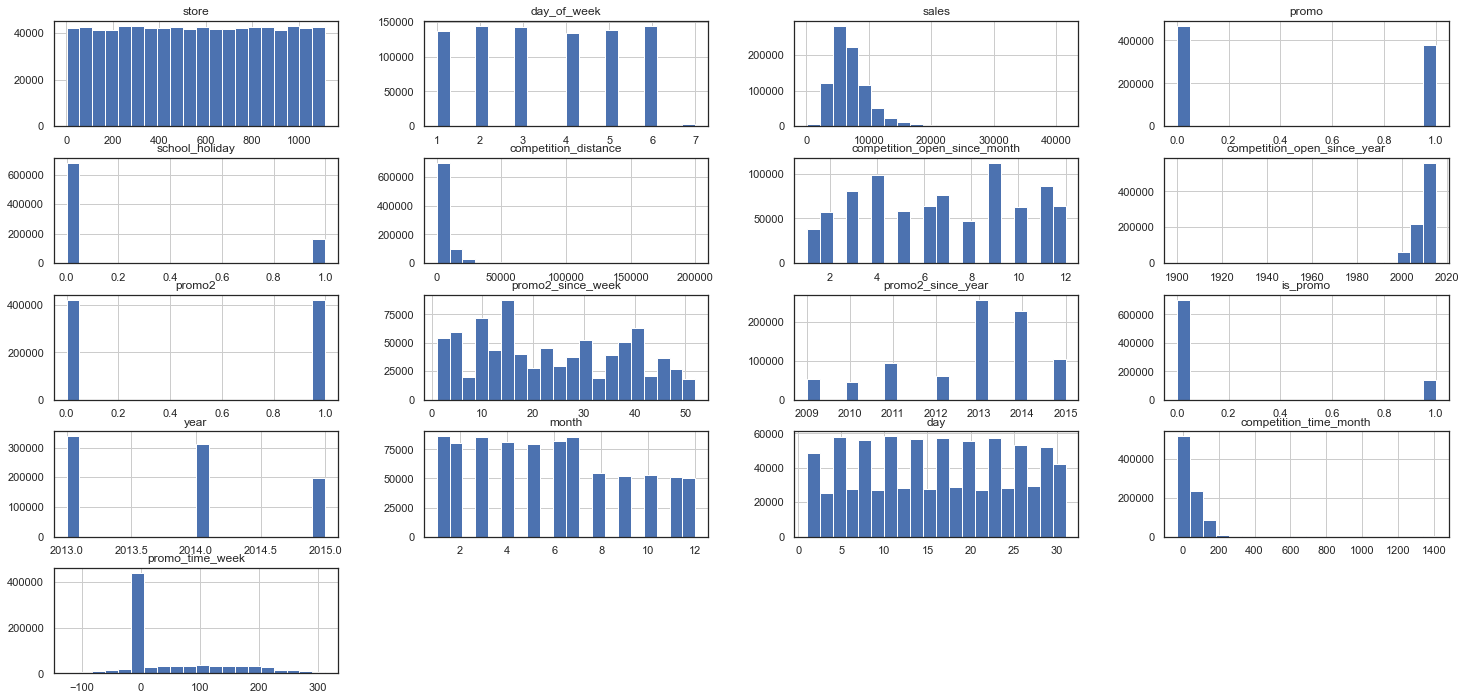

In [32]:
num_attributes.hist( bins = 20 );

**Some Conclusions:**

* it seems that there are more competitores close than far and the are more new competitors;
* day_of_week, if analysed on its own, doesn't seem to have any kind of pattern;


### 4.1.3. Categorical Analysis

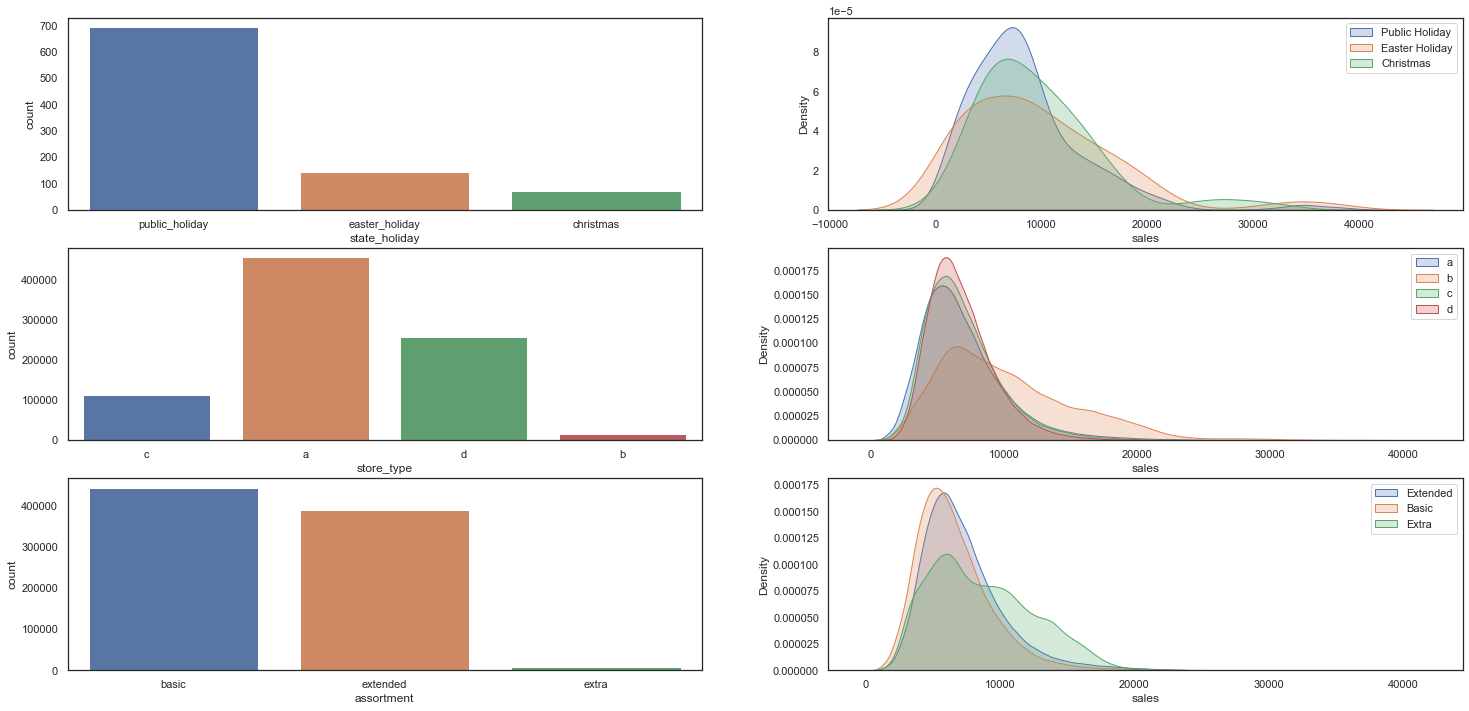

In [36]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public Holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter Holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', shade=True )
plt.legend()

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='Extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade=True )
plt.legend();

**Conclusions:**

* There's a difference for the three types of state holiday. Based on that difference, the model could better adjust its predictions i, for isntance, it's christmas period;
* For different type of stores, sales have a different behavior. For instance, store of type b have sales less concentrated than the others;
* there's no much difference between assortments extended and basic, but it's clear that they are different than Extra.

In sum, all these three features are considered important to the model since they can bring information about the target variable.

## 4.2. Bivariate Analysis - Hypothesis Validation

Now, it's time to see if those hypothesis I made are true or false. To do that, they'll be validated one by one.

**In sum I'll basically do:**
* validate the hypothesis;
* conclude if the feature is important to use in the model.

### H1. Stores with a larger assortment should sell more.
**False**: On average, 'extended', which is stores with a higher level of assortment, has a quite similar sales mean to that of 'basic' assortment stores. Analysing over the weeks, we can see that the mean for them have movements quite similar. Since stores with 'extra' assortment have the higher mean, we can conclude that assortment feature is important to the model.

In [56]:
# counting values for each class in assortment
for index,value in zip(df4['assortment'].value_counts().index, df4['assortment'].value_counts()):
    print(index,value)

basic 444875
extended 391254
extra 8209


--> since there's a difference in quantity between all three classes, I'll use the average as a comparison. Furthermore, I'll concentate in 'basic' and 'extended' which are two extremes of the feature.

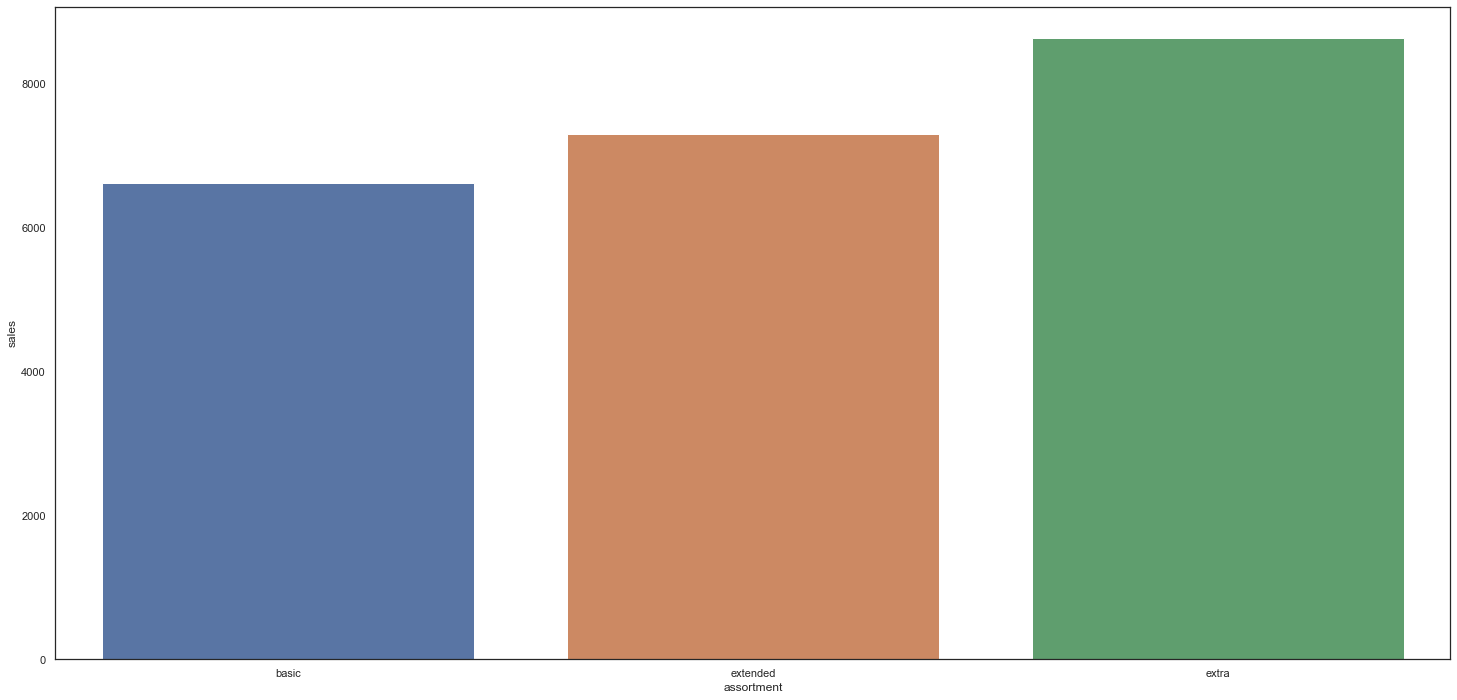

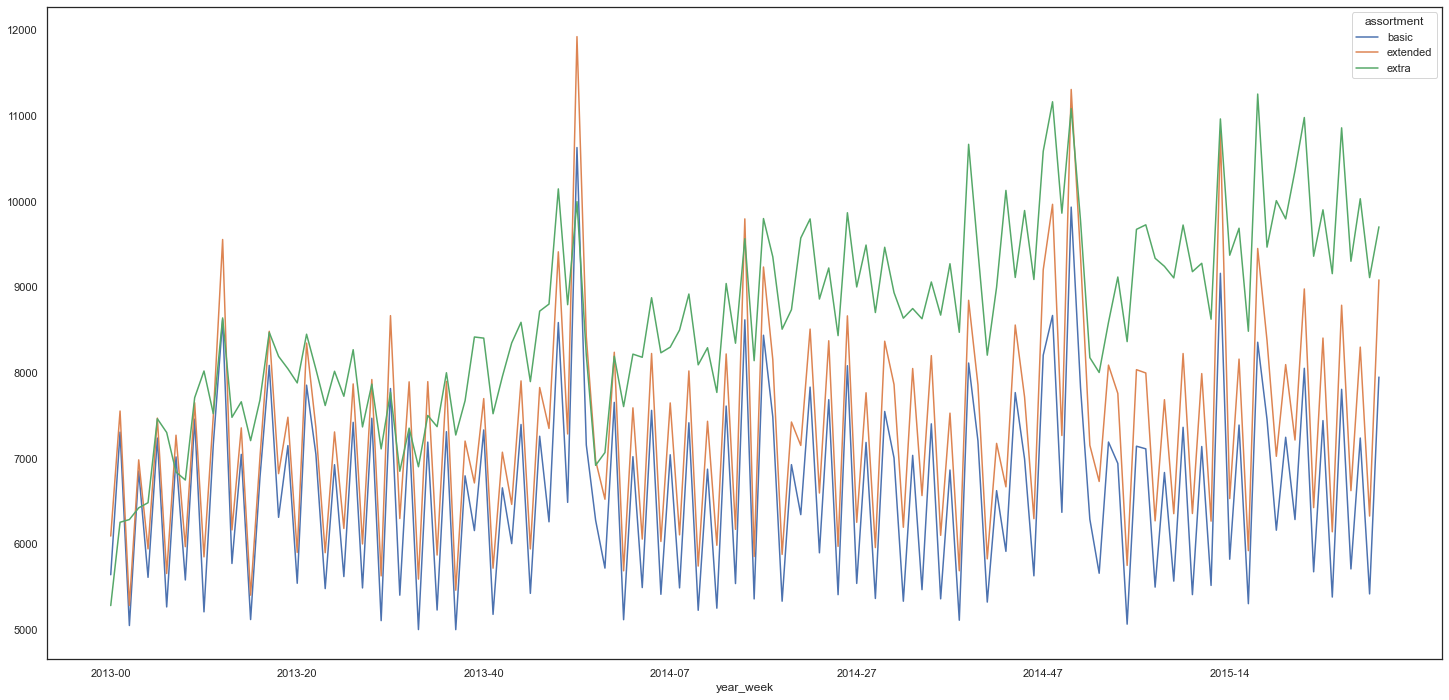

In [50]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data = aux1 )

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### H2. Stores with closer competitors should sell less.
**False:** stores with closer competitors sell more. Competition distance and sales have a negative non linear correlaiton, which means that as the distance increases, sales decrease. That correlation (-0.23) is good enough to consider the variable important to the model.

I'll create groups for competition_distance to better visualize.

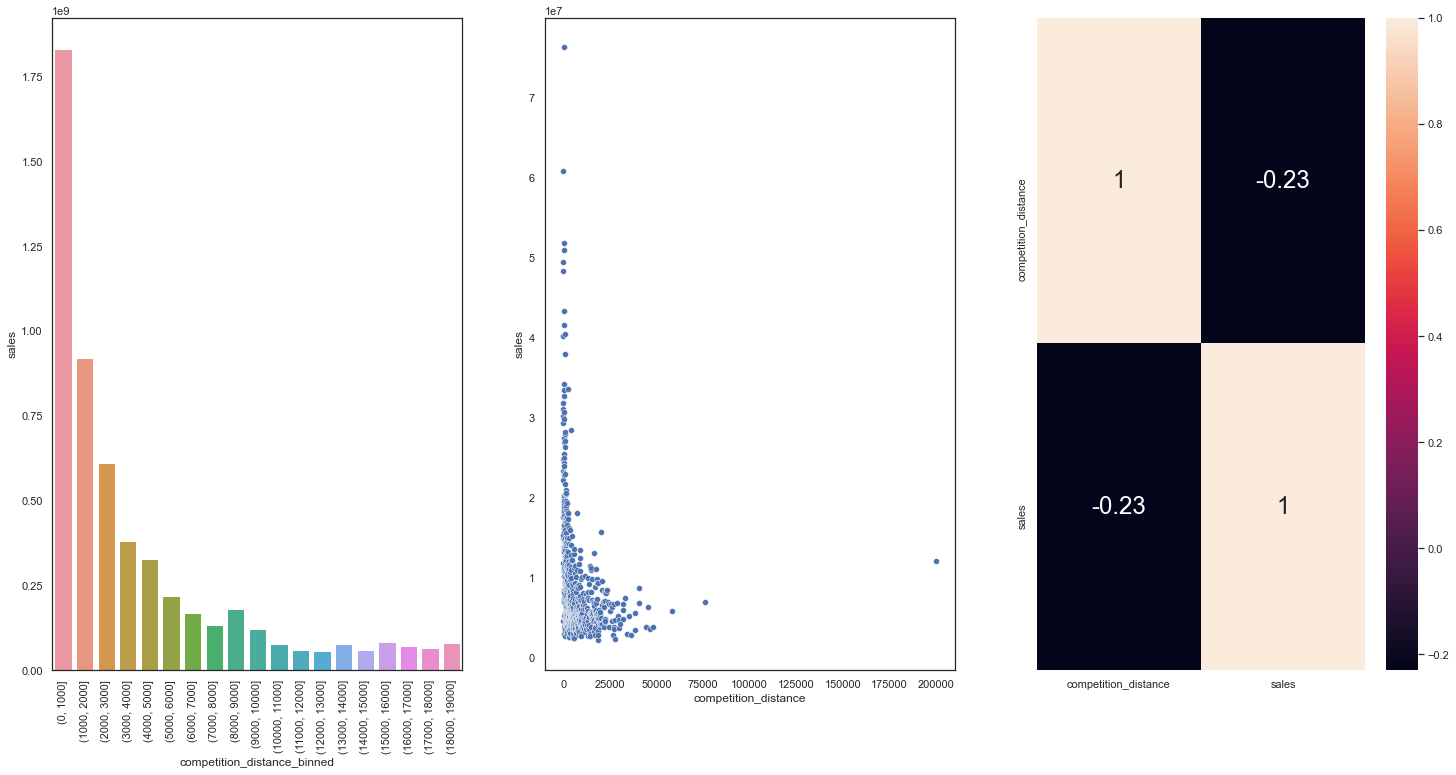

In [79]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# creating bins to group the data by bins to better visualize
bins = list( np.arange(0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='competition_distance_binned', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 )

plt.subplot( 1, 3, 2 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot = True );

### H3. Stores with longer competitors should sell more
**False:** the more recent the competition, the higher the sale. The feature is relevant to the model because its correlation with the target is not to close to zero.

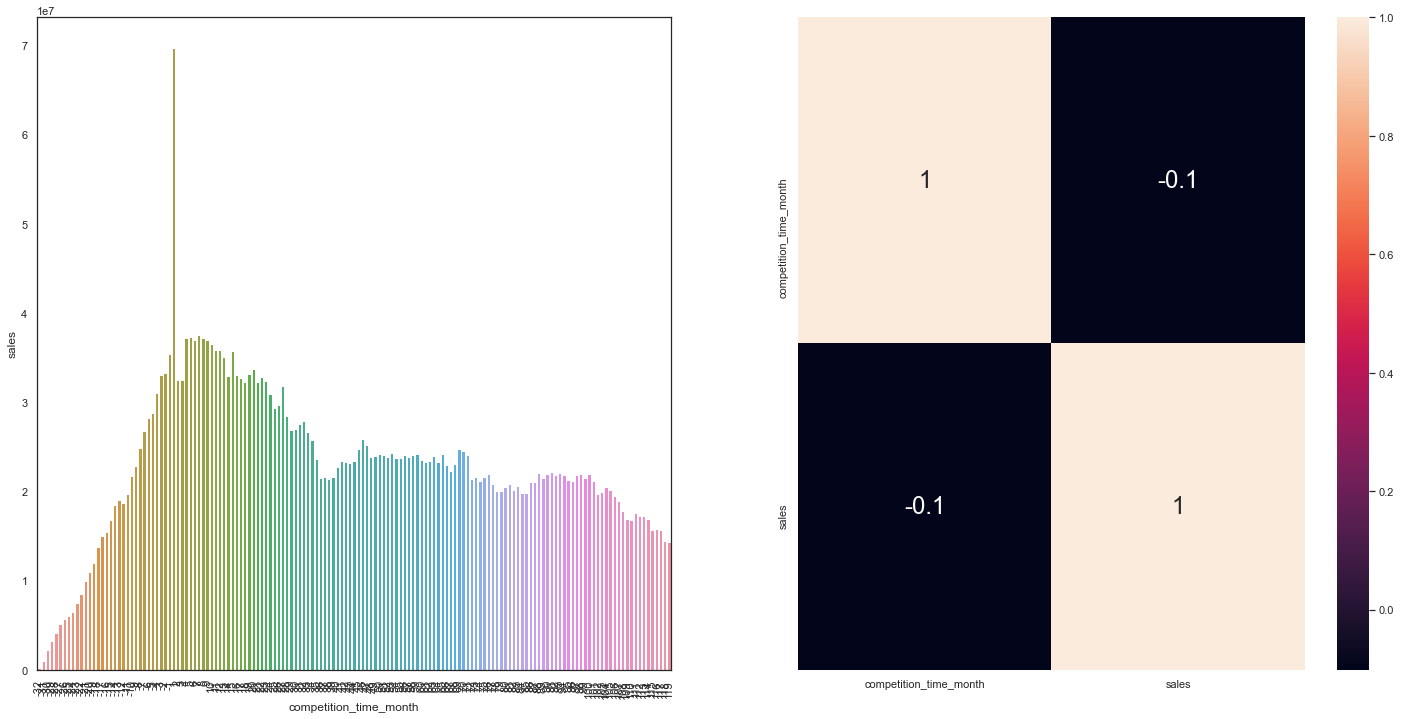

In [80]:
aux1 = df4[ ['competition_time_month', 'sales'] ].groupby( 'competition_time_month' ).sum().reset_index()
plt.subplot( 1, 2, 1 )
aux2 = aux1[ ( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]
sns.barplot( x='competition_time_month', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 )

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot = True );

### H4. Stores with active promotions for longer should sell more.
**False:** stores with active promotions for longer sell less because sales starts to decrease after a period of time. According to the correlation, there's no evidence of a strong relationship between this feature and the target.

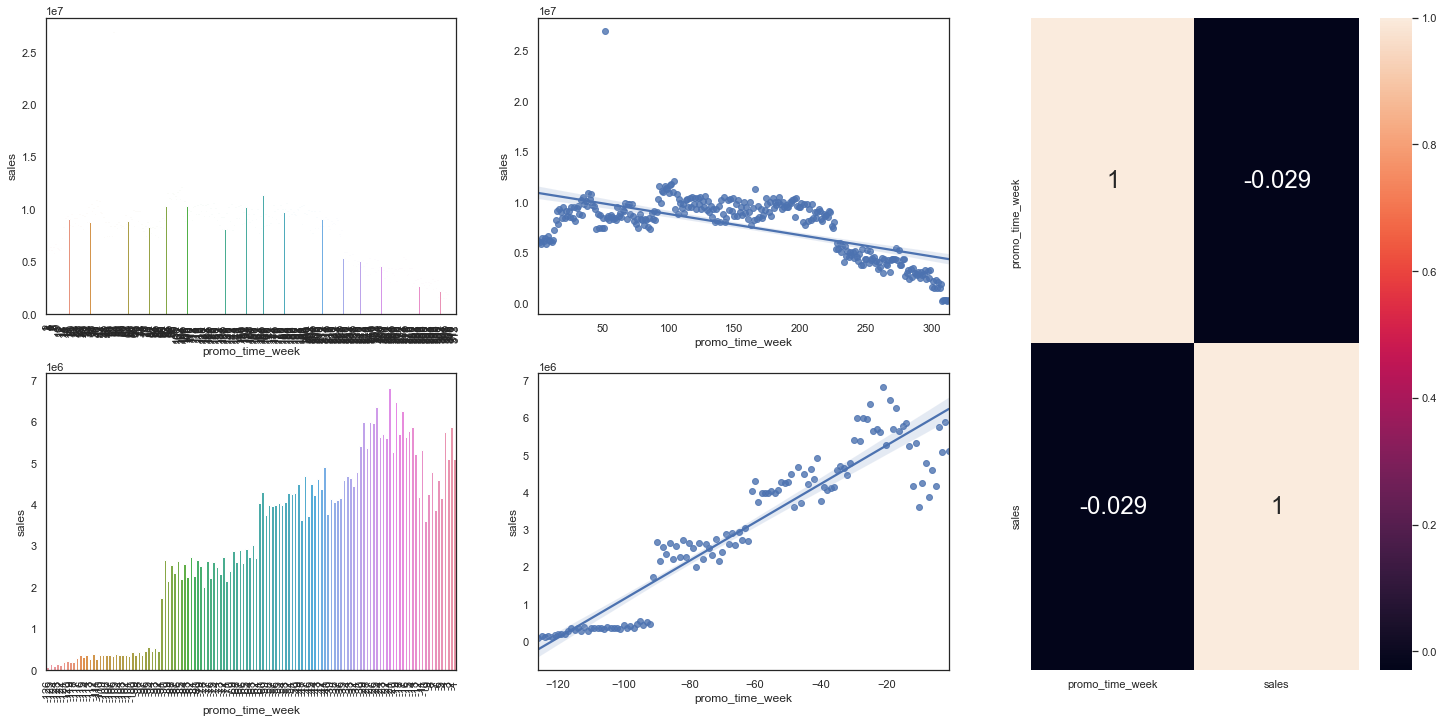

In [84]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promotion
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>H5. Stores with more promotion days should sell more.</s>
it'll be validated in the second CRISP cycle.

### H6. Stores with more consecutive promotions should sell more.
**False:** stores with more consecutive promotions sell less. There's no such an evidence of a strong relationship between this feature and the targ.

In [86]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


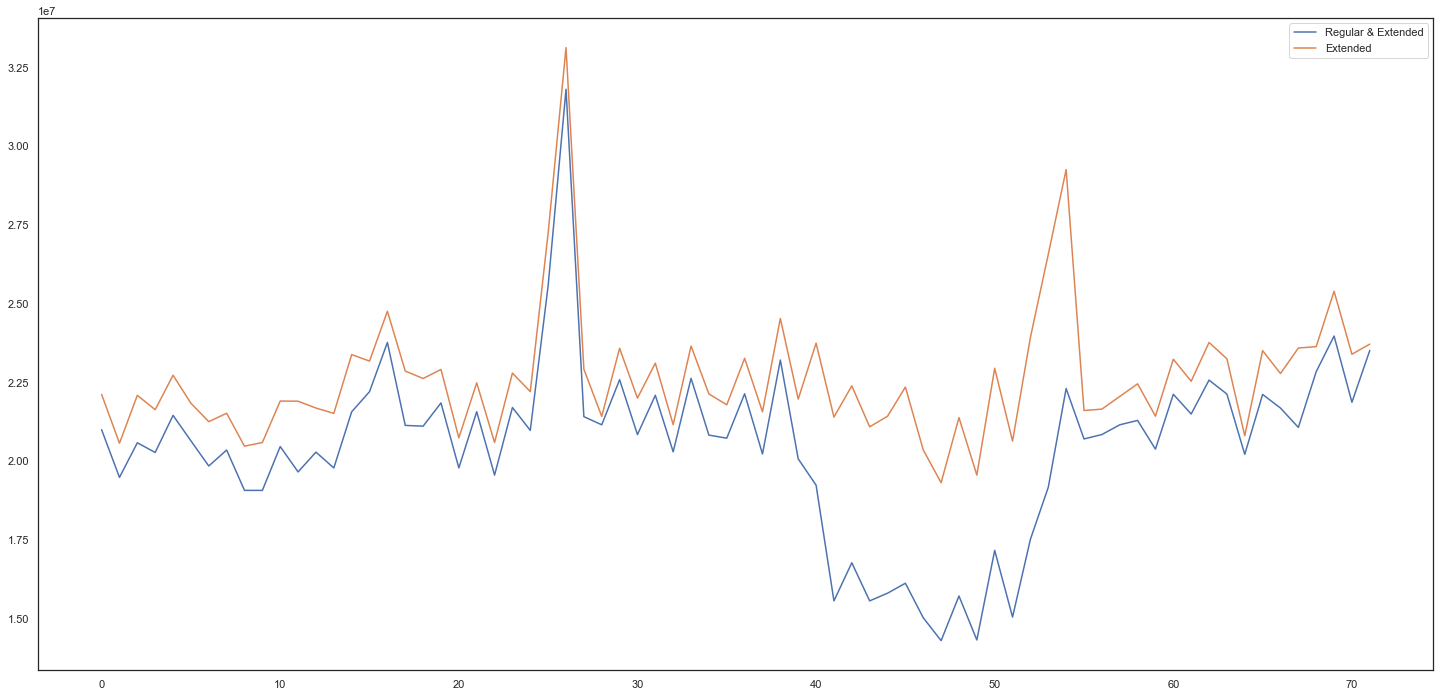

In [90]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular & Extended', 'Extended']);

### H7. Stores open during the Christmas holiday should sell more.
**False:** On average, Stores open during christmas have one of the highest sales amount, but easter holiday has a higher mean. In fact, stores sell more during holidays than during regular days. So, this featuer can be considered important to the analysis.

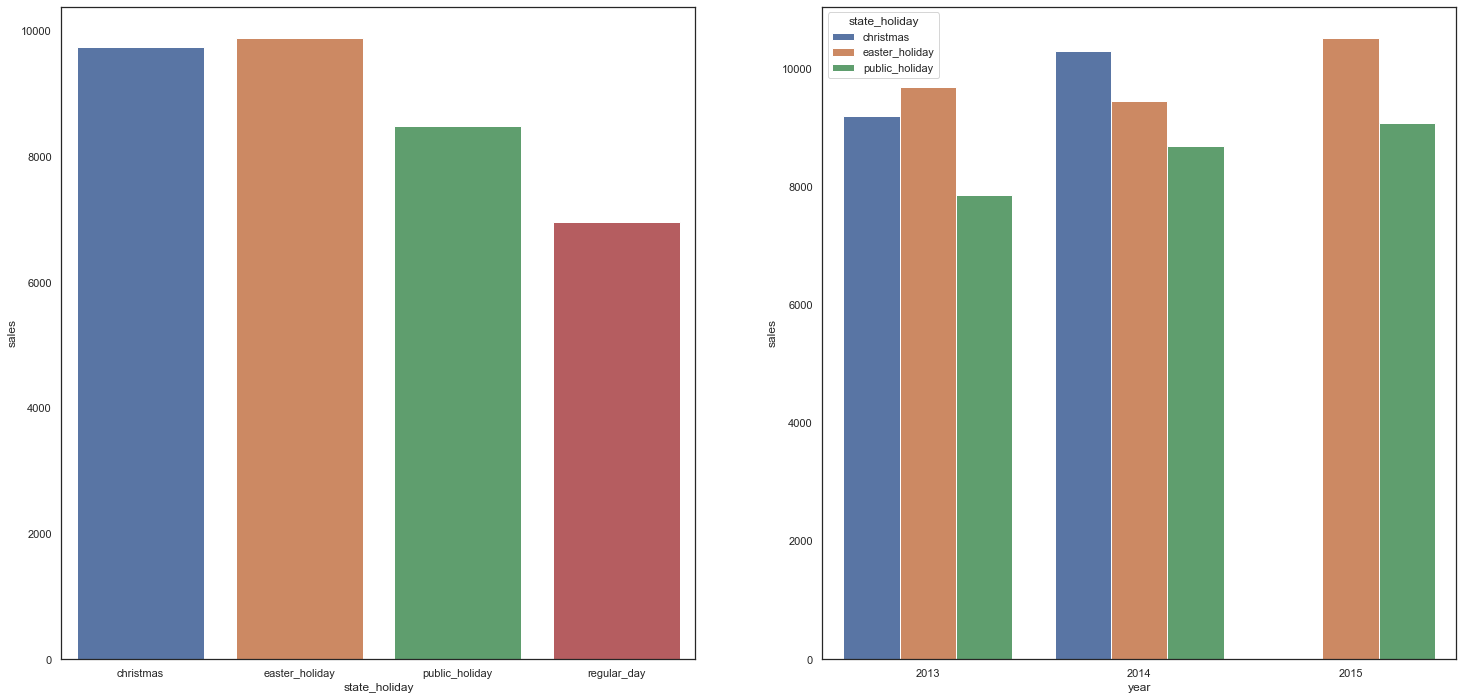

In [93]:
aux1 = df4[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 2, 2 )
aux = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H8. Stores should be selling more over the years.
**True:** On average, sales are increasing over the year. Since the correlation is very high, this feature is important to the model.

Since 2015 is no completed yet, it's better to use mean instead of sum.

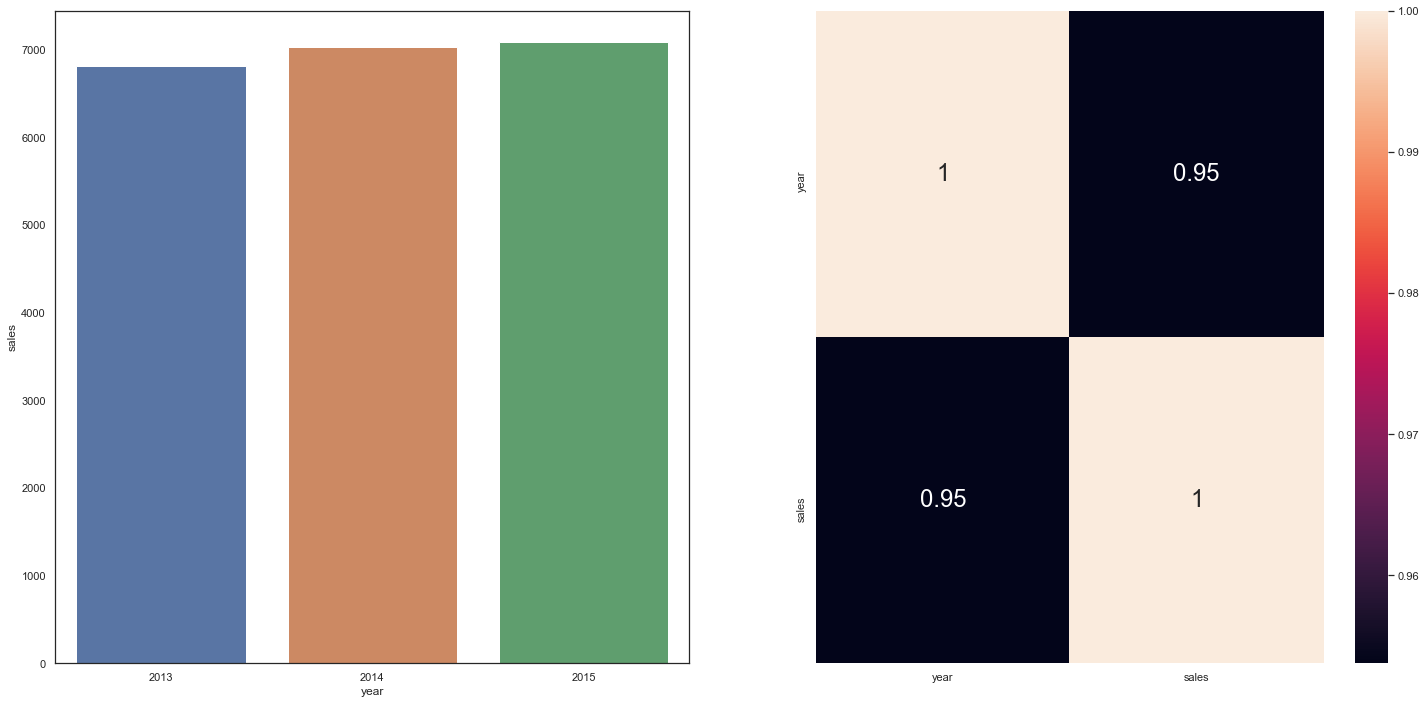

In [107]:
aux1 = df4[['year', 'sales',]].groupby( 'year' ).mean().reset_index()

plt.subplot( 1, 2, 1)
sns.barplot( x='year', y='sales', data=aux1)

plt.subplot( 1, 2, 2)
sns.heatmap( aux1.corr(method = 'pearson'), annot=True);

### H9. Stores should sell more in the second half of the year.
**False:** Stores sell less in the second half of the year. The feature and the target have a strong negative correlation and it can be considered important to the model.

Since 2015 is incomplete, I'll use mean instead of the sum to compare because the lack of data for the second half of the year will give us misinformation.

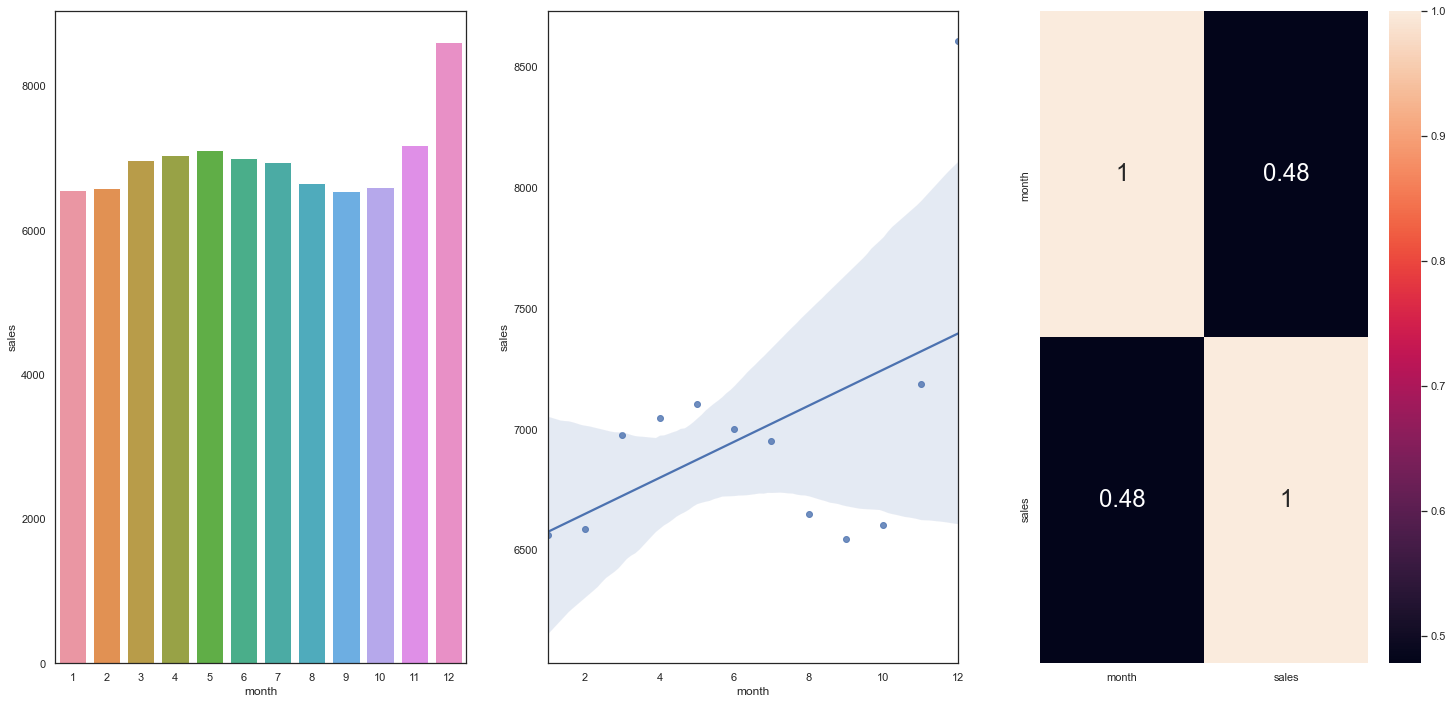

In [144]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Stores should sell more after the 10th of each month.
**False:** on average, stores there's no such an strong evidence that stores sell more after teh 10th day of each month. In fact, the mean for this class is slightly smaller than for 'before_10_days'. The correlation between the feature and the target shows a relevant relationship. thus, It can be considered important to the model.

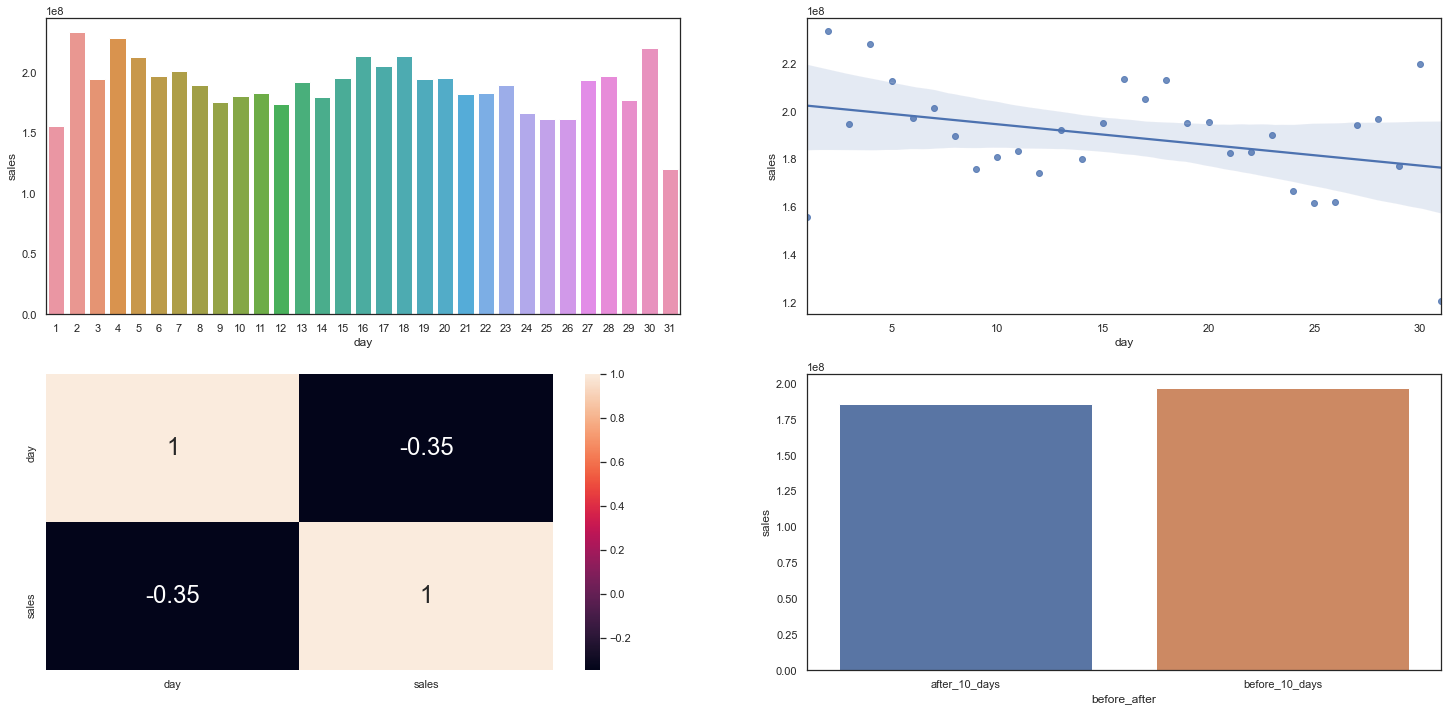

In [119]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#creating a columns to analyse before and after the 10th day
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Stores should sell less on weekends.
**False:** one average, I can't say that sales is less on weekends. The correlation is strong enough to be considered in the model.

In [122]:
df4['day_of_week'].value_counts()

6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: day_of_week, dtype: int64

Since there's less sundays in the dataset, I'll use the mean to compare the sale by days.

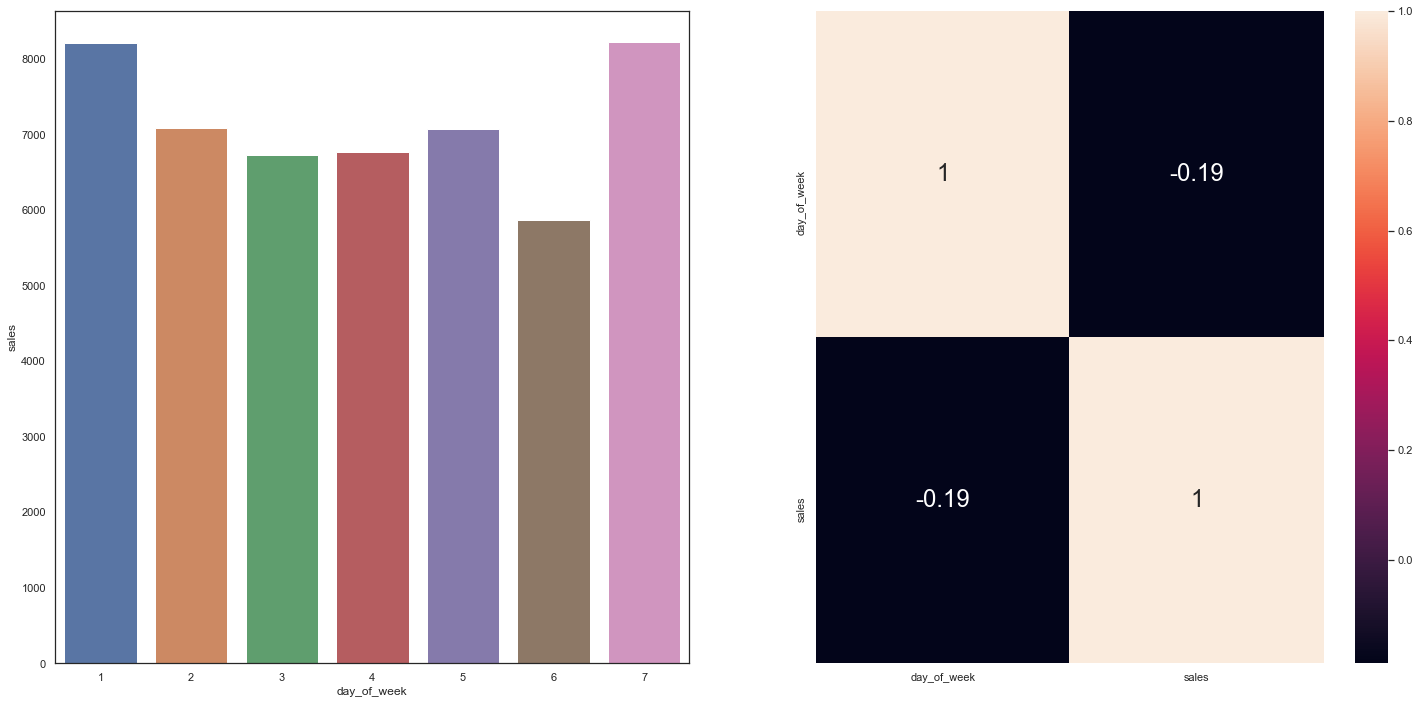

In [123]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Stores should sell less during school holidays.
**False:** there's no such an evidence that stores sell less during school holidays. On average, it's almost thesame.

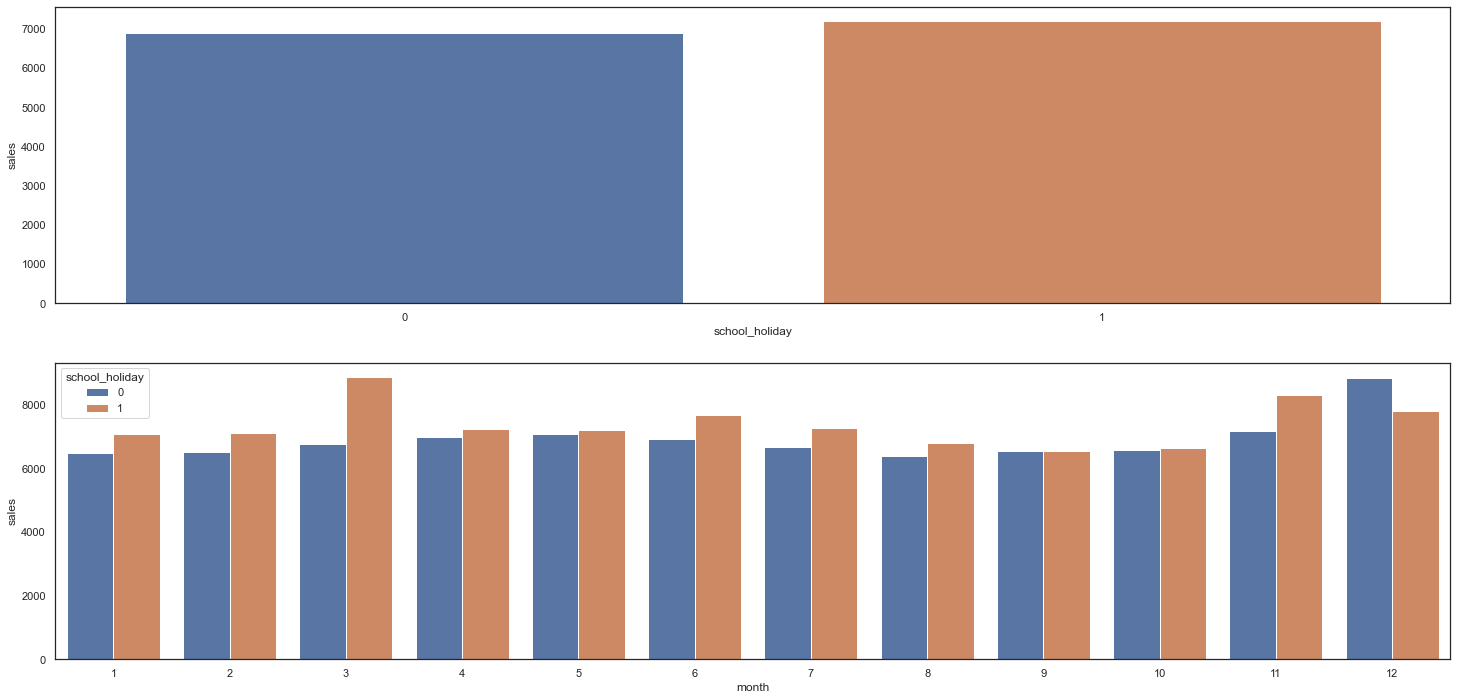

In [124]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Hypothesis Validation Summary

In [145]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Medium'],  
      ['H2', 'False', 'Medium'],  
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Medium'],
      ['H8', 'True', 'High'],
      ['H9', 'False', 'Medium'],
      ['H10', 'False', 'Medium'],
      ['H11', 'False', 'Medium'],
      ['H12', 'False', 'Low'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Medium
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            True          High
H9            False         Medium
H10           False         Medium
H11           False         Medium
H12           False         Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

In [156]:
num_attributes.corr( 'pearson' ).style.background_gradient()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
store,1.000000,0.000343,0.007723,-0.000015,0.000526,-0.014427,-0.033376,-0.000141,0.007728,0.005348,0.014475,0.004680,0.000300,0.001371,-0.000127,0.001924,-0.015256
day_of_week,0.000343,1.000000,-0.178753,-0.289268,-0.139319,0.003168,-0.006484,0.001594,-0.003252,-0.006624,0.004078,-0.000054,0.002099,-0.019710,0.008525,-0.001917,-0.008131
sales,0.007723,-0.178753,1.000000,0.368199,0.038635,-0.041545,-0.003629,0.012437,-0.127556,0.082069,0.071753,-0.063010,0.036151,0.073589,-0.051865,-0.003571,-0.057257
promo,-0.000015,-0.289268,0.368199,1.000000,0.028971,-0.001359,-0.001796,0.000491,-0.000316,0.003583,0.004779,0.003629,0.023990,-0.006412,-0.126442,0.002295,0.003838
school_holiday,0.000526,-0.139319,0.038635,0.028971,1.000000,-0.003256,0.040614,-0.001356,-0.008244,0.036423,-0.004498,0.017292,-0.038686,0.118467,0.038085,-0.000047,0.000939
competition_distance,-0.014427,0.003168,-0.041545,-0.001359,-0.003256,1.000000,-0.037215,0.039208,-0.104955,-0.024320,0.050614,-0.047325,0.000065,0.000711,-0.000189,-0.037391,-0.047303
competition_open_since_month,-0.033376,-0.006484,-0.003629,-0.001796,0.040614,-0.037215,1.000000,-0.139848,-0.033036,0.108603,0.028361,-0.038241,-0.086342,0.318716,-0.001684,0.093740,-0.034146
competition_open_since_year,-0.000141,0.001594,0.012437,0.000491,-0.001356,0.039208,-0.139848,1.000000,-0.014570,-0.010944,0.003851,-0.009623,0.045702,-0.008538,0.000280,-0.989574,0.018103
promo2,0.007728,-0.003252,-0.127556,-0.000316,-0.008244,-0.104955,-0.033036,-0.014570,1.000000,-0.026169,-0.627189,0.447307,-0.005696,-0.025807,0.001355,0.014187,0.634461
promo2_since_week,0.005348,-0.006624,0.082069,0.003583,0.036423,-0.024320,0.108603,-0.010944,-0.026169,1.000000,-0.161805,-0.011707,-0.125877,0.476939,0.021192,0.011794,0.017704


### 4.3.2. Categorical Attributes

For categorical attributes I'm going to use Cramér's V test. Basically, it is a measure of association between two categorical variables and it returns a value between 0 and 1. Its formula is the following:

$$V = \sqrt{\frac{\chi^2/n}{min(k-1,r-1)}}$$

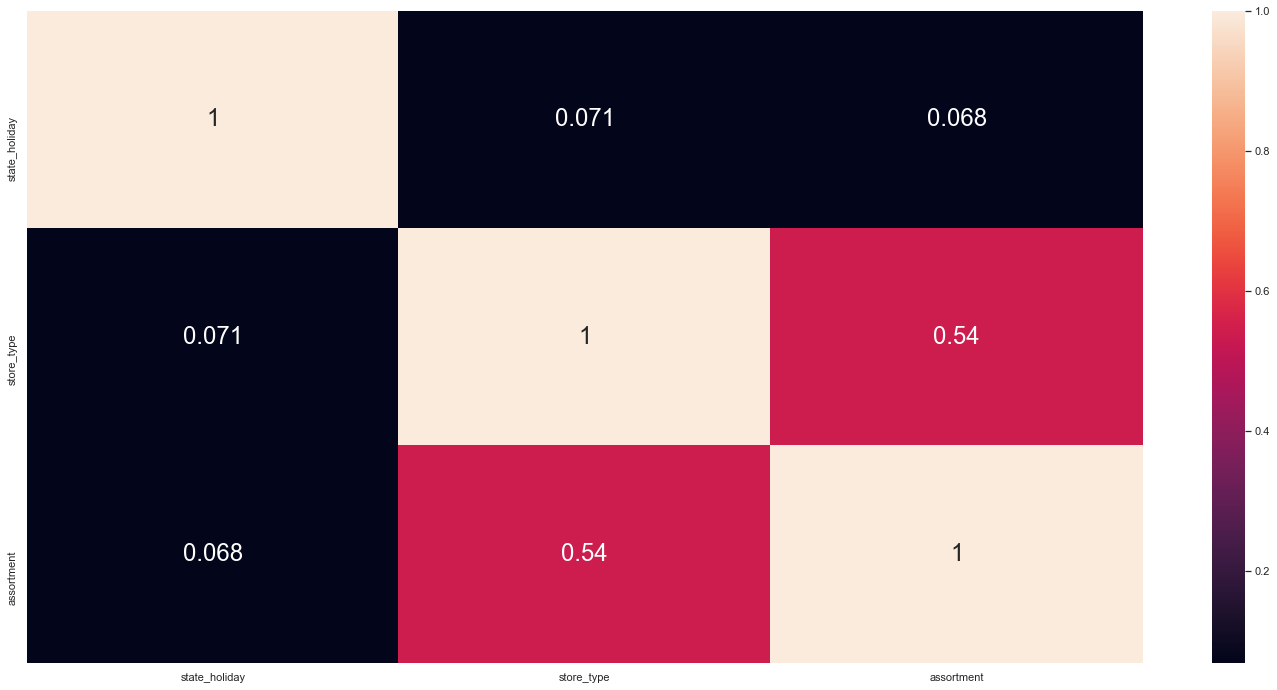

In [183]:
# gettingonly categorical data
a = df4.select_dtypes( include='object' )

# Calculating cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0. STEP 5: DATA PREPARATION

In [27]:
df5 = df4.copy()

## 5.1. Normalization

Based on subsection 4.1.2, there's no evidence that the numerical variables have a normal distribution. So, I won't normalize any of them.

## 5.2. Rescaling

In [37]:
rs = RobustScaler()
miax = MinMaxScaler()

# competition distance: there are relevant outliers, so, I'll use robust scaler
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# year
df5['year'] = miax.fit_transform( df5[['year']].values )

# competition time month: there are relevant outliers, so, I'll use robust scaler
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week: even though there are less relevance of outliers, I'll use robust scaler
df5['promo_time_week'] = rs.fit_transform( df5[['promo_time_week']].values )

## 5.3. Transforming

### 5.3.1. Encoding

For this first CRISP cycle, I'll use the following enconding techniques and if it doesn't perform well, I change it in the next cycle.

In [44]:
# state holiday: one hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store type: label encoder
le = LabelEncoder()
df5['storetype'] = le.fit_transform( df5['store_type'] )

# assortment: ordinal encoding
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

ML algoriths needs the response to be normal (or close to that). Thus, I'll perform a log transformation on the target variable.

In [45]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

The goal here is to transform variables with a cyclic nature ( like day, week, month). To do that, I'll get the sin and cosin for each observation and make them new columns.

In [54]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )